In [1]:
# Import 
import os
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from itertools import permutations
import time
import pandas as pd
from joblib import dump, load
from pathlib import Path

## sourceXray
from src.sourceXray_BJ import sourceXray, compute_C, solve_H_right_inverse
from src.utils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# CB data (keep all measurements, just remove negatives in pm25mpm1)
df_org = pd.read_csv("data/CB_10locs_complete_nonegpm25mpm1.csv") 
df = df_org.copy()

In [4]:
print(df.describe().T) 

              count        mean         std        min         25%  \
location   451948.0    3.844542    3.062748   1.000000    1.000000   
bulldozer  360877.0    0.455324    0.498001   0.000000    0.000000   
downwind   451948.0    0.313939    0.464092   0.000000    0.000000   
temp       451948.0   11.667070    8.124815 -13.300000    6.000000   
windspeed  451948.0    2.787878    2.481150   0.000000    1.050000   
humid      451948.0   55.193653   20.667384   6.300000   38.800000   
solar      450616.0  153.428325  246.293511   0.000000    0.000000   
stable     450616.0    0.722265    0.447883   0.000000    0.000000   
pm1        451948.0    8.372516    6.347728   0.089628    4.207575   
pm25mpm1   451948.0    0.922400    1.357985   0.000000    0.280713   
pm10mpm25  451948.0   14.890649   36.580698   0.000000    1.737550   
tspmpm10   451948.0   10.854552  162.024831   0.000000    0.000000   
bc         451948.0    0.805215    1.292752 -10.711287    0.248560   
co         451948.0 

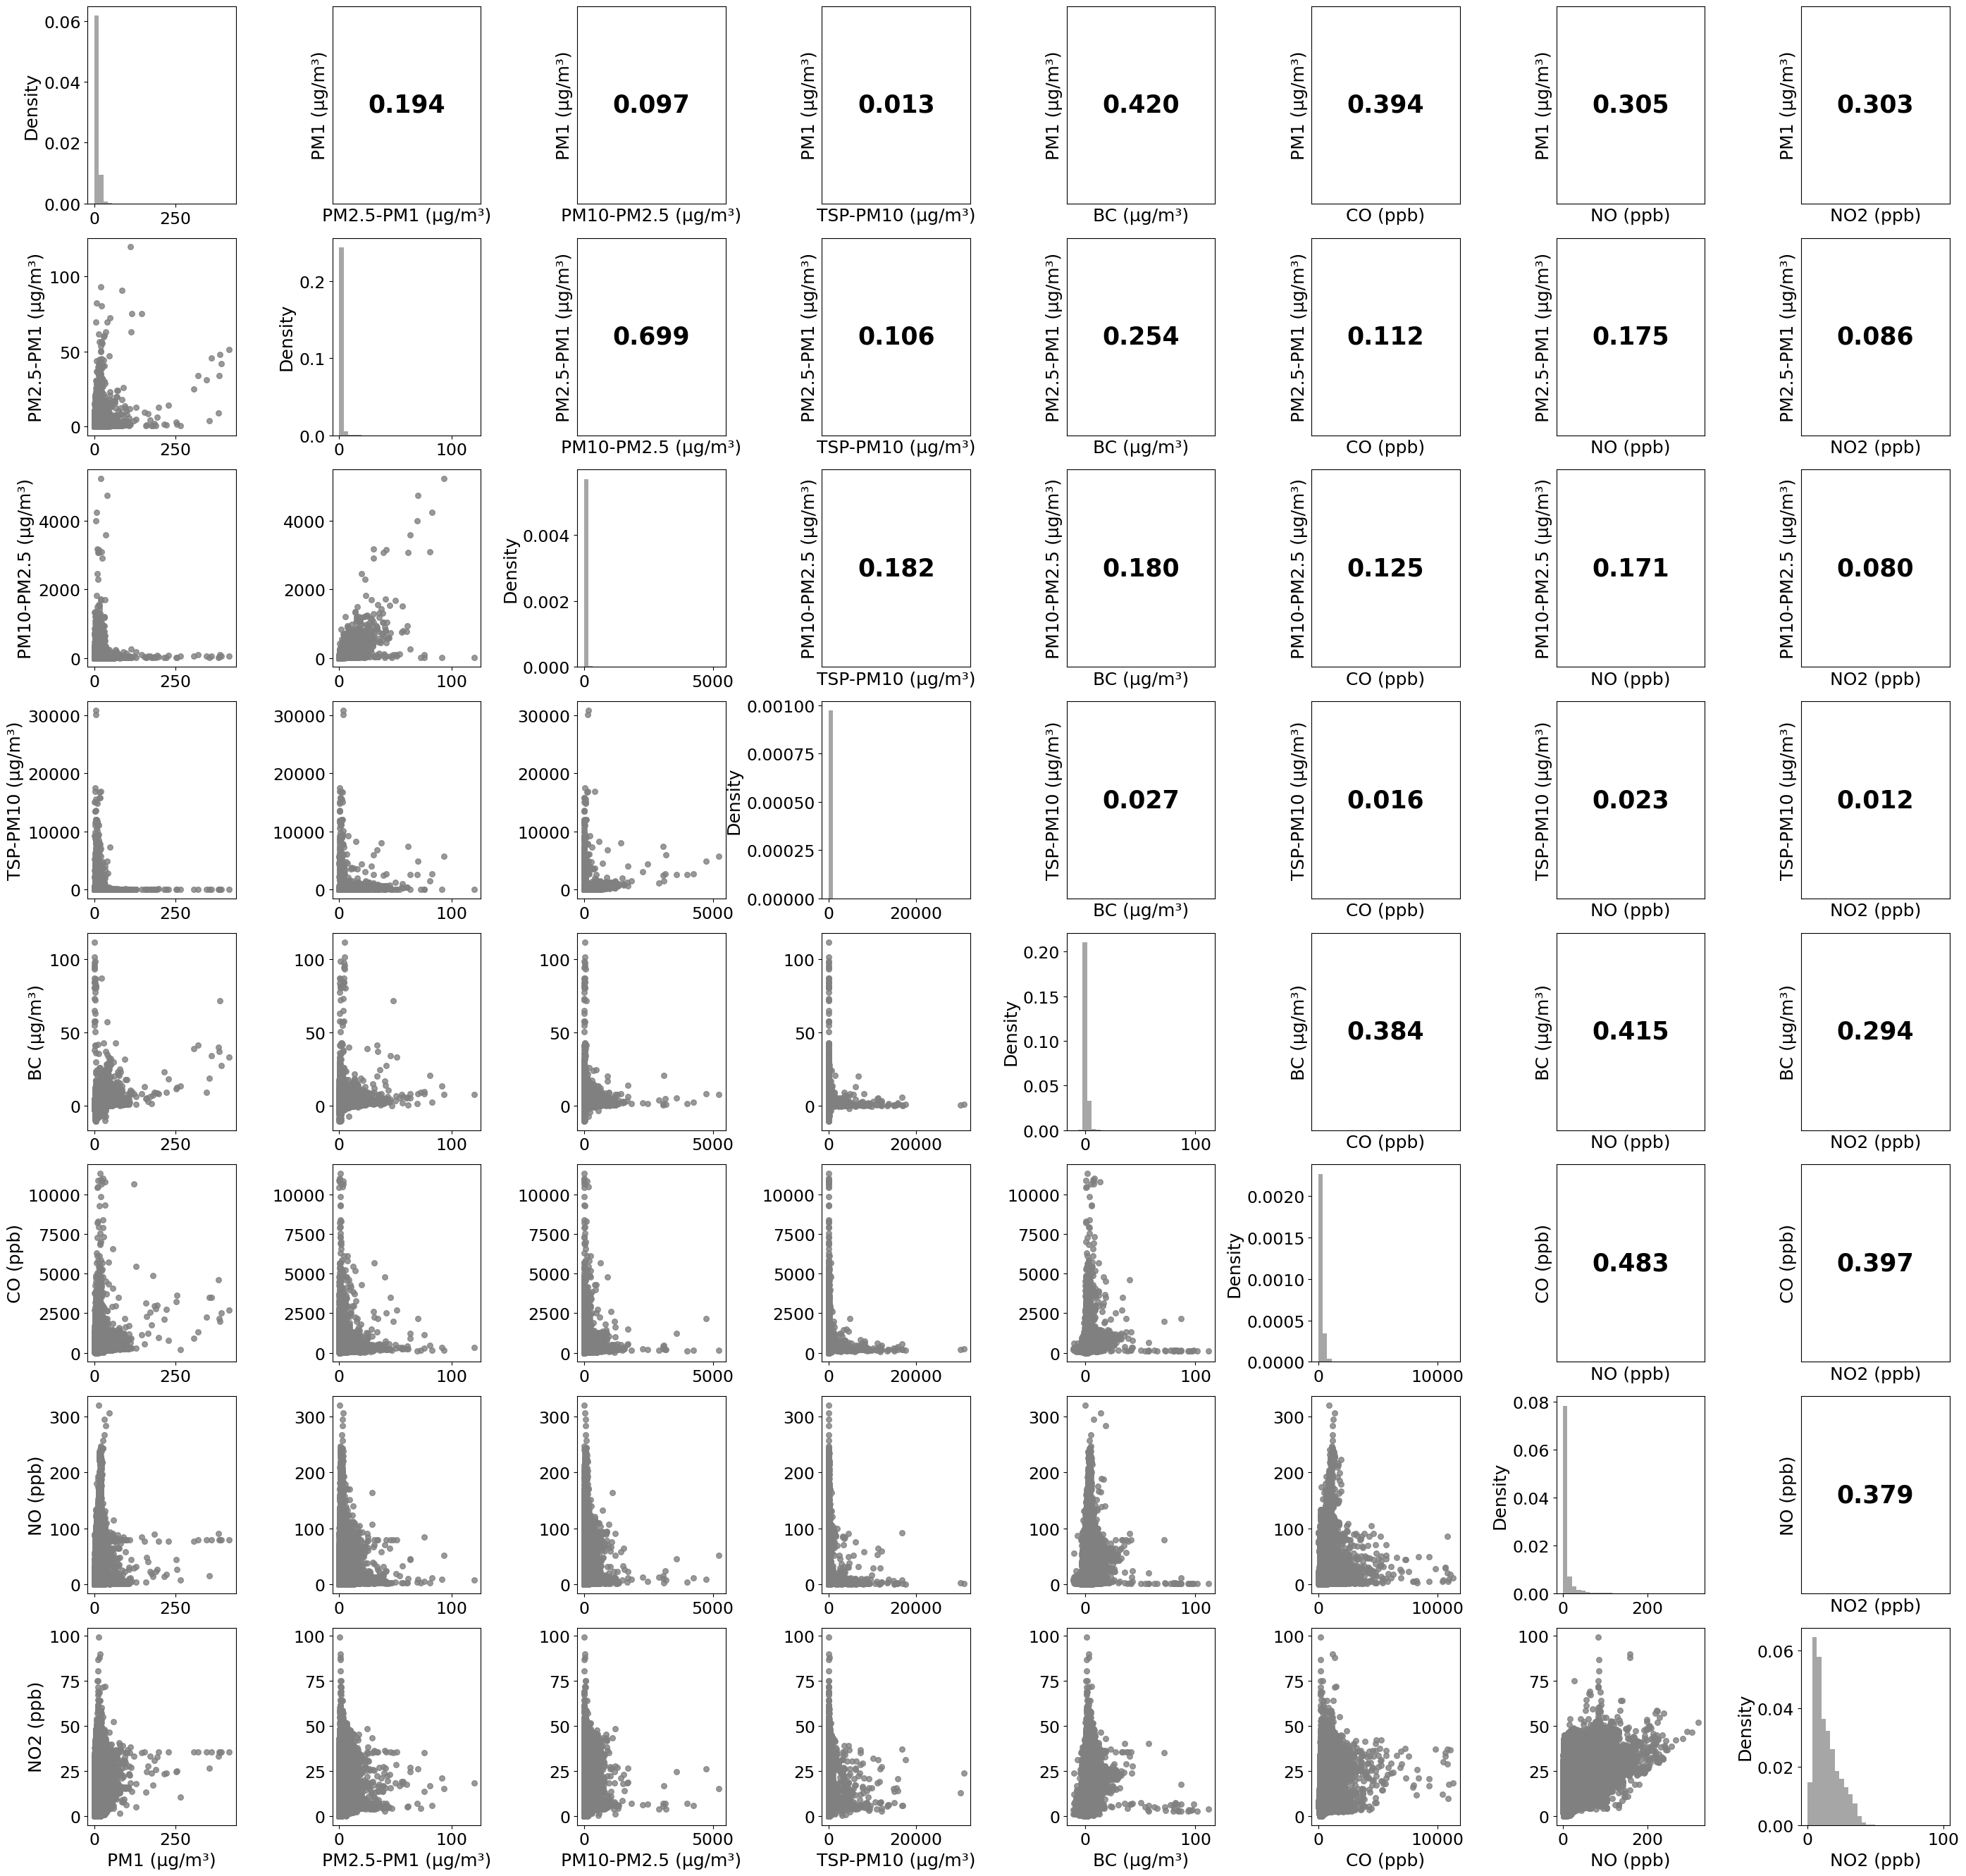

In [5]:
ys = ['pm1', 'pm25mpm1', 'pm10mpm25', 'tspmpm10', 'bc', 'co', 'no', 'no2']
col_label_mu=["PM1 (µg/m³)", "PM2.5-PM1 (µg/m³)", "PM10-PM2.5 (µg/m³)", "TSP-PM10 (µg/m³)", 
              "BC (µg/m³)", "CO (ppb)", "NO (ppb)", "NO2 (ppb)"]
plot_full_scatter_matrix(df[ys],
                         alpha=0.8, 
                         labels=col_label_mu,
                         draw_diagonal=True,
                         title=None, 
                         quantile=None,
                         convexhull=False,
                         draw_upper_corr=True,
                         corr_fmt="{:.3f}",
                         corr_fontsize=25,          
)

In [6]:
# remove clear outliers (2 points TSP-PM10 > 25000) 
mask = df["tspmpm10"] > 25000
n_removed = mask.sum()
df = df.loc[~mask].reset_index(drop=True)

In [7]:
print(df.describe().T) 

              count        mean         std        min         25%  \
location   451946.0    3.844523    3.062742   1.000000    1.000000   
bulldozer  360877.0    0.455324    0.498001   0.000000    0.000000   
downwind   451946.0    0.313936    0.464091   0.000000    0.000000   
temp       451946.0   11.667073    8.124832 -13.300000    6.000000   
windspeed  451946.0    2.787886    2.481153   0.000000    1.050000   
humid      451946.0   55.193480   20.667266   6.300000   38.800000   
solar      450614.0  153.429006  246.293846   0.000000    0.000000   
stable     450614.0    0.722263    0.447883   0.000000    0.000000   
pm1        451946.0    8.372533    6.347737   0.089628    4.207570   
pm25mpm1   451946.0    0.922389    1.357977   0.000000    0.280712   
pm10mpm25  451946.0   14.889989   36.579422   0.000000    1.737535   
tspmpm10   451946.0   10.719751  148.813007   0.000000    0.000000   
bc         451946.0    0.805216    1.292755 -10.711287    0.248560   
co         451946.0 

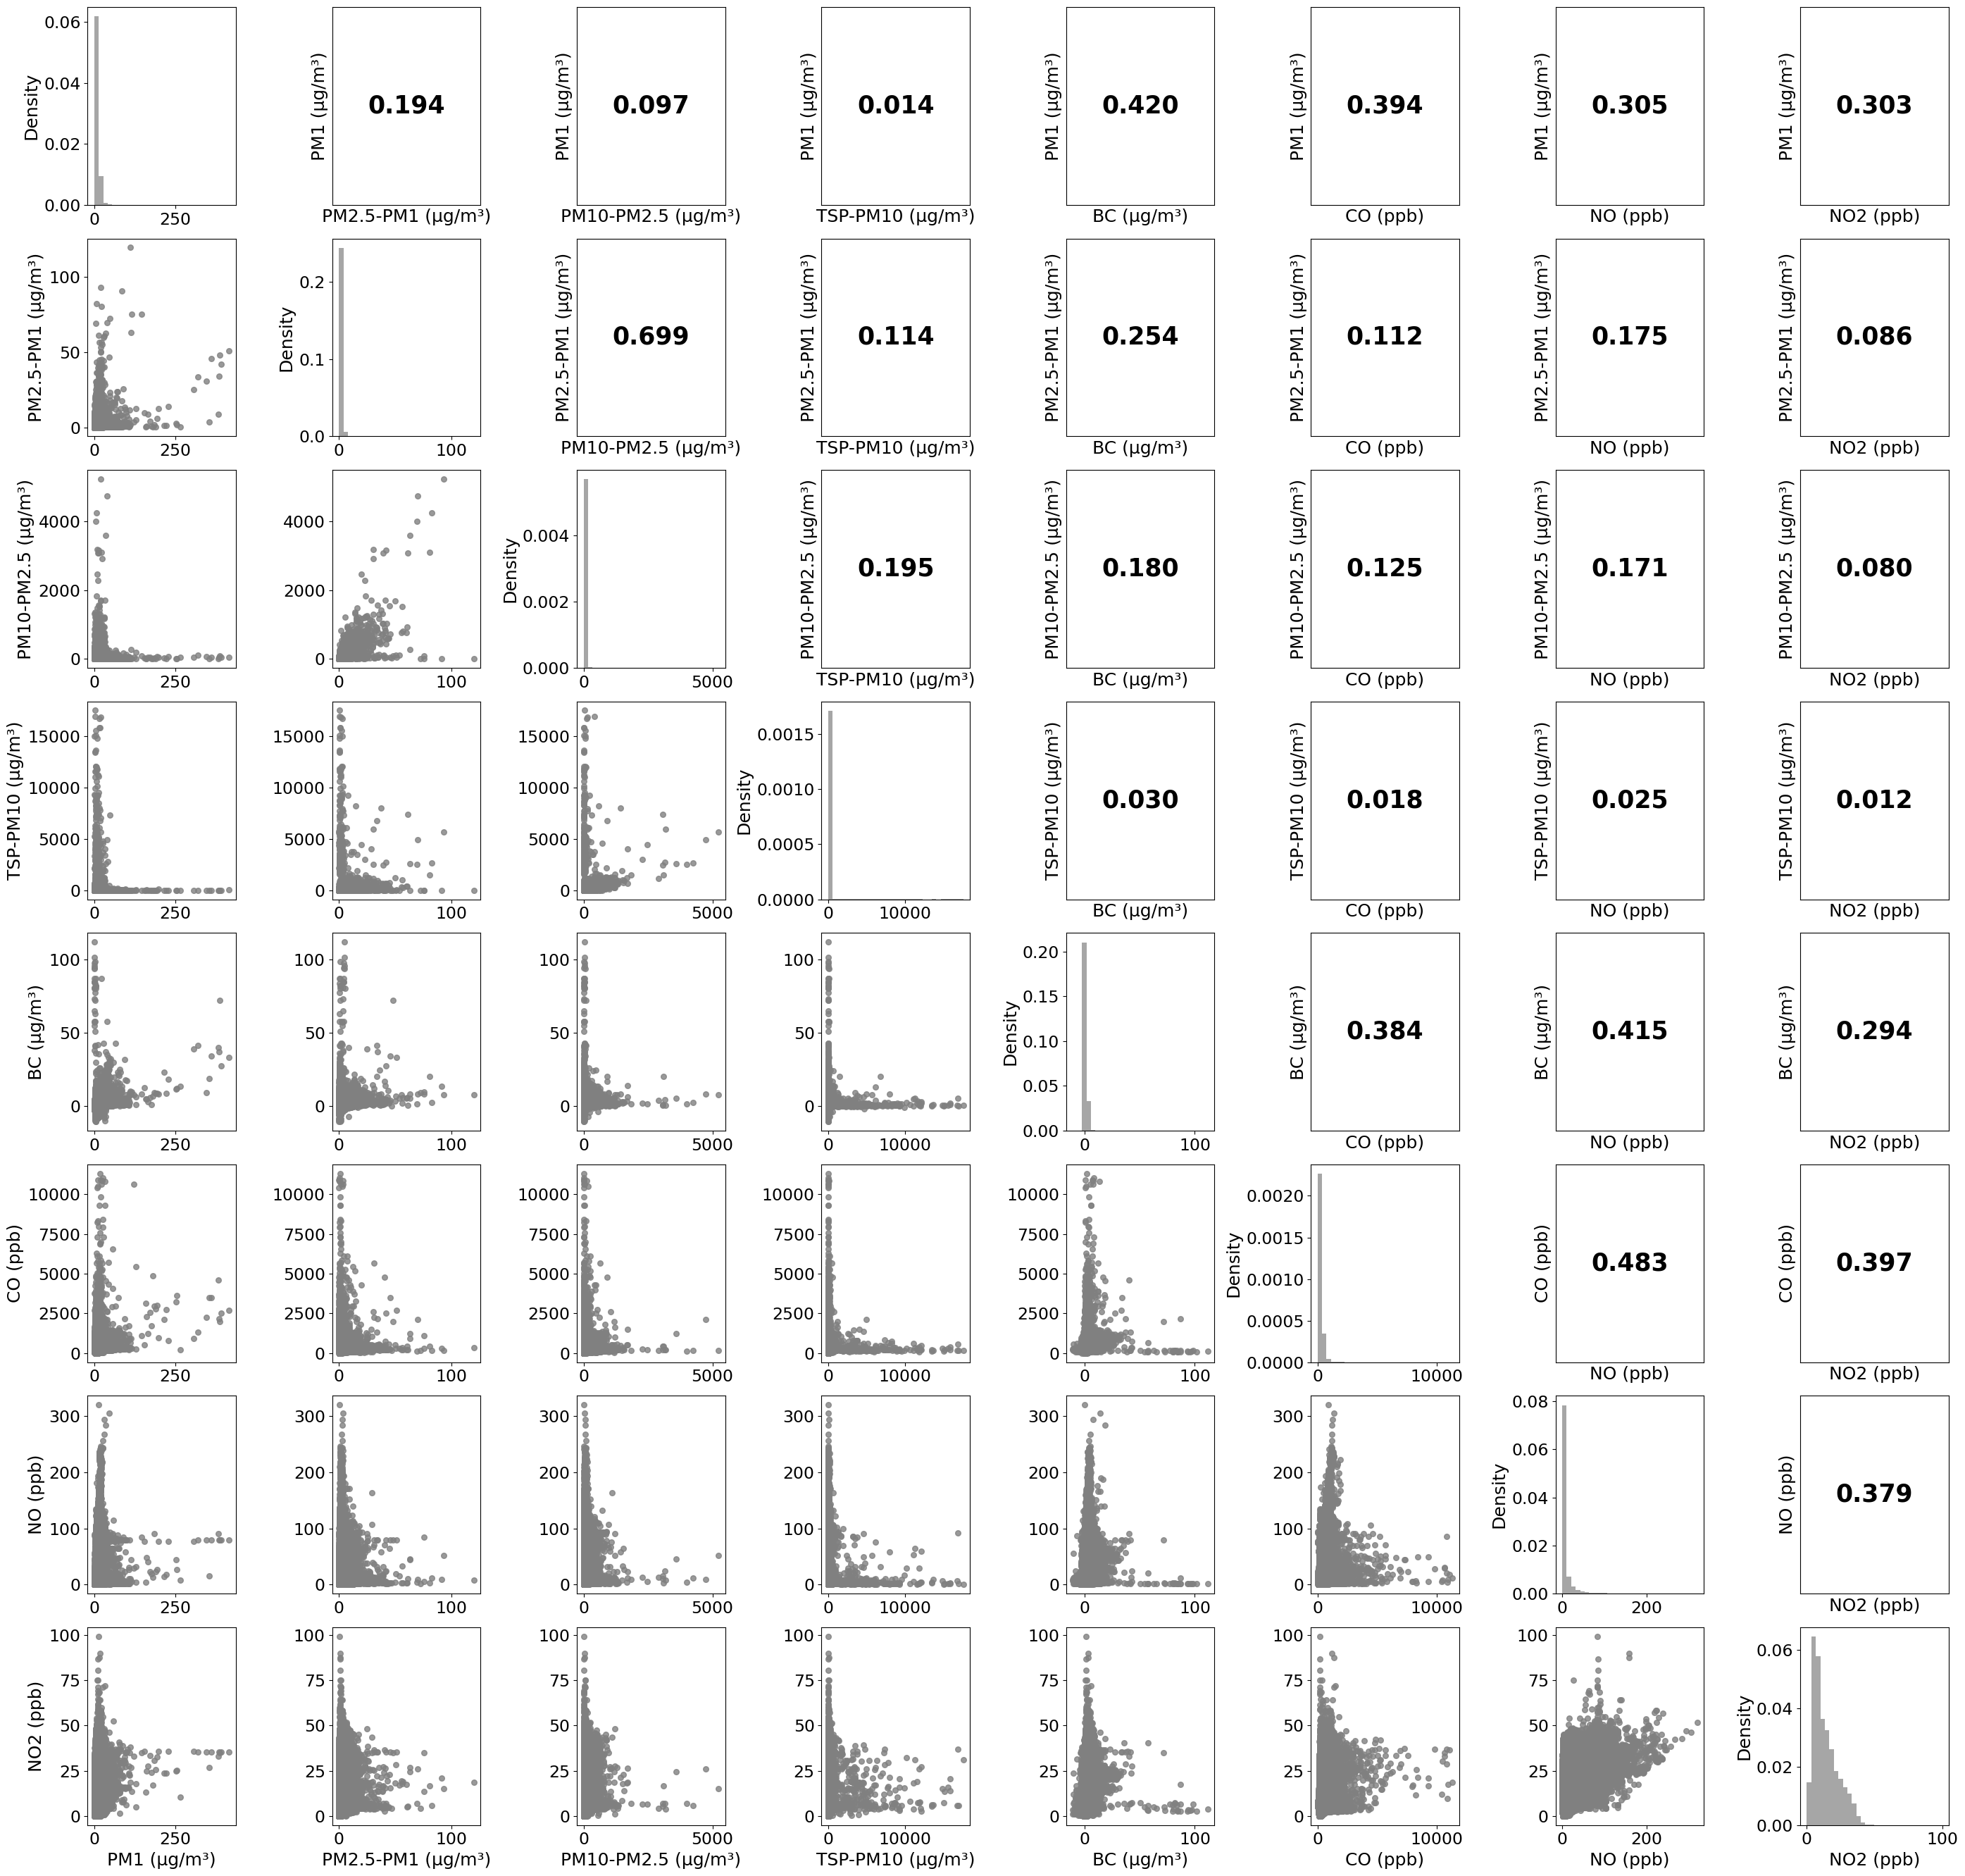

In [8]:
plot_full_scatter_matrix(df[ys],
                         alpha=0.8, 
                         labels=col_label_mu,
                         draw_diagonal=True,
                         title=None, 
                         quantile=None,
                         convexhull=False,
                         draw_upper_corr=True,
                         corr_fmt="{:.3f}",
                         corr_fontsize=25,          
)

In [9]:
# Extract pollutant columns (pm1 to no2)
Y_org = df.loc[:, ys]

# Standardize (subtract min(min, 0) and divide by range to 85th percentile)
Y = Y_org.copy()
for col in Y.columns:
    iqnr_j = np.diff(np.quantile(Y[col], [0, 0.85], axis=0))
    min_j = Y[col].min()
    if min_j < 0: 
        Y[col] = Y[col] - min_j
    Y[col] = Y[col]/iqnr_j
# df.loc[:, ys] = Y.values

# Parse your 'date' column (strings like "2025-02-22 00:01:00 UTC") to timezone-aware datetimes
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
local = df['date'].dt.tz_convert('America/New_York')
df['date_local'] = local

# AM = 1 if hour < 12, else 0 (noon and later → 0)
df['am'] = (df['date'].dt.hour < 12).astype('int')  

# Categorical variable
for col in ['bulldozer', 'downwind', 'am', 'stable']:
    df[col] = pd.Categorical(df[col], categories=[0, 1])   # control baseline=0
df['location'] = pd.Categorical(df['location'], categories=[1,2,5,8])   # control baseline=1

In [22]:
dump({'df': df, 'Y': Y}, "data/CB_10locs_complete_nonegpm25mpm1.joblib")

['data/CB_10locs_complete_nonegpm25mpm1.joblib']

In [23]:
df['location'].value_counts(dropna=False).sort_index()

location
1    158100
2    110148
5     36821
8    146877
Name: count, dtype: int64